=== Starting Proper FedAvg ===
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 0 Class Distribution:
Train: {'Demented': 0, 'Non Demented': 1}
Train counts: (array([0, 1]), array([10980, 10980], dtype=int64))
Val counts: (array([0, 1]), array([2745, 2745], dtype=int64))
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 1 Class Distribution:
Train: {'Demented': 0, 'Non Demented': 1}
Train counts: (array([0, 1]), array([10980, 10980], dtype=int64))
Val counts: (array([0, 1]), array([2745, 2745], dtype=int64))
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 2 Class Distribution:
Train: {'Demented': 0, 'Non Demented': 1}
Train counts: (array([0, 1]), array([10980, 10980], dtype=int64))
Val counts: (array([0, 1]), array([2745, 2745], dtype=int64))
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 3 Class Distribution:

c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.4712 - loss: 0.6932
Epoch 2/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5138 - loss: 0.6931
Client 0 Final Train Accuracy: 0.5010
Training Client 1...
Epoch 1/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.4970 - loss: 0.6931
Epoch 2/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.4870 - loss: 0.6933
Client 1 Final Train Accuracy: 0.4958
Training Client 2...
Epoch 1/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.4608 - loss: 0.6932
Epoch 2/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.4844 - loss: 0.6932
Client 2 Final Train Accuracy: 0.4948

Validation Metrics:
F1: 0.6667 | Accuracy: 0.5000 | AUC: 0.5000
Class Distribution in Predictions: (array([1]), array([5490], dtype=int64))

Round 2/10
Training Client 0...
Epoch 1/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5313 - loss: 0.6932
Epoch 2/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.4848 - los


Validation Metrics:
F1: 0.6667 | Accuracy: 0.5000 | AUC: 0.5000
Class Distribution in Predictions: (array([1]), array([5490], dtype=int64))


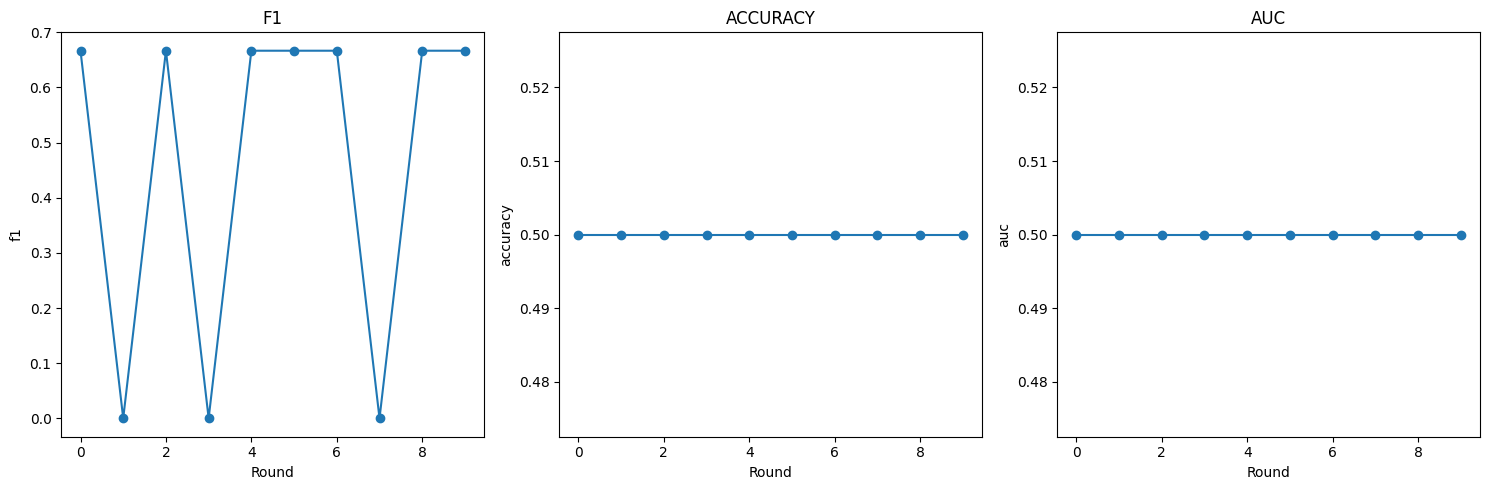

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

# Configuration
TRAIN_PATH = "C:/Users/musab/PycharmProjects/DataScienceGame/LOHITH_NEW/archive/Data/train"
VAL_PATH = "C:/Users/musab/PycharmProjects/DataScienceGame/LOHITH_NEW/archive/Data/val"
MODEL_PATH = "central_alzheimer_model.h5"
NUM_CLIENTS = 5
ROUNDS = 10
BATCH_SIZE = 32  # Increased batch size
TARGET_SIZE = (128, 128)

def create_client_datasets():
    """Create balanced client datasets with proper validation"""
    clients = []
    for client_id in range(NUM_CLIENTS):
        # Client-specific augmentations
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20 + client_id*5,  # Varies per client
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            brightness_range=[0.9, 1.1]
        )
        
        val_datagen = ImageDataGenerator(rescale=1./255)
        
        # Train generator
        train_gen = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size=TARGET_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=True,
            seed=42 + client_id
        )
        
        # Fixed validation generator
        val_gen = val_datagen.flow_from_directory(
            VAL_PATH,
            target_size=TARGET_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False,
            seed=42
        )
        
        # Verify balance
        print(f"\nClient {client_id} Class Distribution:")
        print(f"Train: {train_gen.class_indices}")
        print(f"Train counts: {np.unique(train_gen.labels, return_counts=True)}")
        print(f"Val counts: {np.unique(val_gen.labels, return_counts=True)}")
        
        clients.append({
            'train': train_gen,
            'val': val_gen,
            'train_steps': len(train_gen),
            'val_steps': len(val_gen)
        })
    return clients

def build_model():
    """Build a fresh model with proper initialization"""
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(128, 128, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

def run_fedavg():
    print("=== Starting Proper FedAvg ===")
    clients = create_client_datasets()
    global_model = build_model()  # Use fresh model instead of loading
    
    history = {'round': [], 'f1': [], 'accuracy': [], 'auc': []}
    
    for round in range(ROUNDS):
        print(f"\nRound {round + 1}/{ROUNDS}")
        client_weights = []
        
        # Train on 3 clients
        for client_id in range(3):
            client_data = clients[client_id]
            local_model = clone_model(global_model)
            local_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            print(f"Training Client {client_id}...")
            history_local = local_model.fit(
                client_data['train'],
                steps_per_epoch=min(30, client_data['train_steps']),
                epochs=2,  # More epochs per client
                verbose=1
            )
            
            # Debug output
            print(f"Client {client_id} Final Train Accuracy: {history_local.history['accuracy'][-1]:.4f}")
            client_weights.append(local_model.get_weights())
            gc.collect()
        
        # Federated averaging
        avg_weights = [
            np.mean([w[i] for w in client_weights], axis=0)
            for i in range(len(client_weights[0]))
        ]
        global_model.set_weights(avg_weights)
        
        # Proper evaluation
        val_gen = clients[0]['val']
        val_gen.reset()
        y_prob = global_model.predict(val_gen, steps=client_data['val_steps'], verbose=0)
        y_true = val_gen.labels[:len(y_prob)]
        y_pred = (y_prob > 0.5).astype(int)
        
        # Calculate metrics
        f1 = f1_score(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_prob)
        
        history['round'].append(round)
        history['f1'].append(f1)
        history['accuracy'].append(acc)
        history['auc'].append(auc)
        
        print("\nValidation Metrics:")
        print(f"F1: {f1:.4f} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")
        print("Class Distribution in Predictions:", np.unique(y_pred, return_counts=True))
        print("=" * 60)
    
    # Save model
    global_model.save('fedavg_proper_trained.h5')
    
    # Plot results
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(['f1', 'accuracy', 'auc']):
        plt.subplot(1, 3, i+1)
        plt.plot(history['round'], history[metric], 'o-')
        plt.title(metric.upper())
        plt.xlabel("Round")
        plt.ylabel(metric)
    plt.tight_layout()
    plt.show()
    
    return global_model, history

# Run corrected version
proper_model, proper_history = run_fedavg()

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import tqdm  # Progress bars

# =============================================
# 1. Load Data from Folders (Demented/Non Demented)
# =============================================
def load_data(base_path, target_size=(224, 224)):
    """Load JPG images from folders with labels"""
    datagen = ImageDataGenerator(
        rescale=1./255,          # Normalize pixel values
        validation_split=0.2     # Hold out 20% for validation
    )

    print("🔍 Loading images...")
    train_generator = datagen.flow_from_directory(
        base_path,
        target_size=target_size,
        batch_size=32,
        class_mode='binary',     # Binary classification (Demented vs Non-Demented)
        subset='training',       # Training subset
        shuffle=True
    )

    val_generator = datagen.flow_from_directory(
        base_path,
        target_size=target_size,
        batch_size=32,
        class_mode='binary',
        subset='validation',     # Validation subset
        shuffle=False
    )

    return train_generator, val_generator

# =============================================
# 2. Define the CNN Model
# =============================================
def create_model(input_shape=(224, 224, 3)):
    """Simple CNN for Alzheimer's detection"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),  # Better than Flatten for medical images
        Dense(1, activation='sigmoid')  # Binary output
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# =============================================
# 3. Train & Save the Central Model
# =============================================
if __name__ == "__main__":
    # Set your data path
    DATA_PATH = "C:/Users/musab/PycharmProjects/DataScienceGame/LOHITH_NEW/archive/Data"
    
    # 1. Load data
    train_gen, val_gen = load_data(DATA_PATH)
    print(f"✅ Loaded {train_gen.samples} training images")
    print(f"✅ Loaded {val_gen.samples} validation images")

    # 2. Create model
    model = create_model()
    print("\nModel Summary:")
    model.summary()

    # 3. Train the model
    print("\n🎯 Training central model...")
    history = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen,
        verbose=1  # Shows progress bar
    )

    # 4. Save the model
    model.save("central_alzheimer_model(new).keras")
    print("💾 Model saved as 'central_alzheimer_model(new).keras'")

c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 Loading images...
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.
✅ Loaded 21960 training images
✅ Loaded 5490 validation images

Model Summary:


c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)


🎯 Training central model...
Epoch 1/10


c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


687/687 ━━━━━━━━━━━━━━━━━━━━ 152s 219ms/step - accuracy: 0.5423 - auc: 0.5656 - loss: 0.6798 - val_accuracy: 0.7228 - val_auc: 0.7980 - val_loss: 0.5414
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 225s 328ms/step - accuracy: 0.7462 - auc: 0.8095 - loss: 0.5255 - val_accuracy: 0.7222 - val_auc: 0.7905 - val_loss: 0.5410
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 152s 221ms/step - accuracy: 0.7840 - auc: 0.8533 - loss: 0.4658 - val_accuracy: 0.7286 - val_auc: 0.8018 - val_loss: 0.5289
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 151s 220ms/step - accuracy: 0.8045 - auc: 0.8746 - loss: 0.4339 - val_accuracy: 0.7610 - val_auc: 0.8078 - val_loss: 0.5227
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 150s 218ms/step - accuracy: 0.8157 - auc: 0.8903 - loss: 0.4081 - val_accuracy: 0.6933 - val_auc: 0.8220 - val_loss: 0.5501
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 152s 222ms/step - accuracy: 0.8192 - auc: 0.8959 - loss: 0.3968 - val_accuracy: 0.7807 - val_auc: 0.8242 - val_loss: 0.5230
Epoch 7/10
687/687 ━━━━━━━━

📦 Loading model...
✅ Model loaded!
Found 5490 images belonging to 2 classes.
🔍 Predicting...
  1/172 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step

c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step

📊 Classification Report:
              precision    recall  f1-score   support

    Demented       0.82      0.47      0.60      2745
Non Demented       0.63      0.89      0.74      2745

    accuracy                           0.68      5490
   macro avg       0.72      0.68      0.67      5490
weighted avg       0.72      0.68      0.67      5490


📈 ROC AUC Score: 0.8484504032833335


C:\Users\musab\AppData\Local\Temp\ipykernel_19916\3583875497.py:73: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


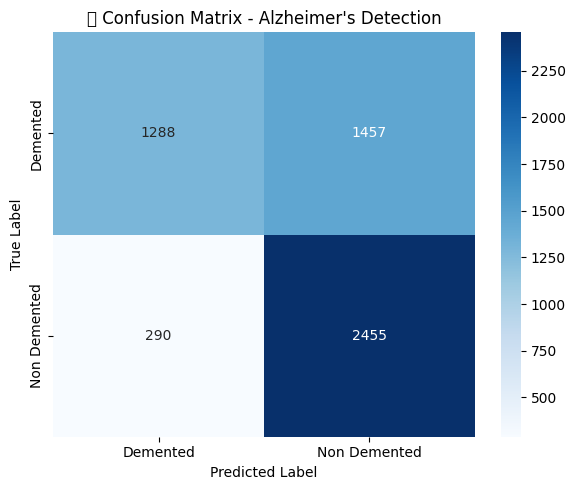

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# Configs
# ===============================
MODEL_PATH = "central_alzheimer_model(new).keras"
DATA_PATH = "C:/Users/musab/PycharmProjects/DataScienceGame/LOHITH_NEW/archive/Data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42  # For reproducibility

# ===============================
# 1. Load the model
# ===============================
print("📦 Loading model...")
model = load_model(MODEL_PATH)

# (Optional but recommended) Recompile to restore metrics if needed
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
print("✅ Model loaded!")

# ===============================
# 2. Prepare validation data
# ===============================
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,   # Important for correct prediction-label alignment
    seed=SEED
)

# ===============================
# 3. Make predictions
# ===============================
print("🔍 Predicting...")
pred_probs = model.predict(val_gen)
preds = (pred_probs > 0.5).astype(int).flatten()
y_true = val_gen.classes

# ===============================
# 4. Evaluation Metrics
# ===============================
print("\n📊 Classification Report:")
print(classification_report(y_true, preds, target_names=list(val_gen.class_indices.keys())))

print("\n📈 ROC AUC Score:", roc_auc_score(y_true, pred_probs))

# ===============================
# 5. Confusion Matrix
# ===============================
cm = confusion_matrix(y_true, preds)
labels = list(val_gen.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("🧠 Confusion Matrix - Alzheimer's Detection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



=== Enhanced Federated Learning ===
Running 15 rounds with 5 epochs per client
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 0 Data:
Training samples: 21960
Validation samples: 5490
Class distribution: {'Demented': 0, 'Non Demented': 1}
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 1 Data:
Training samples: 21960
Validation samples: 5490
Class distribution: {'Demented': 0, 'Non Demented': 1}
Found 21960 images belonging to 2 classes.
Found 5490 images belonging to 2 classes.

Client 2 Data:
Training samples: 21960
Validation samples: 5490
Class distribution: {'Demented': 0, 'Non Demented': 1}


c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Baseline - Accuracy: 0.5996, AUC: 0.6650

=== Round 1/15 ===

Client 0 Training (Epochs: 5)...
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.6914 - loss: 0.8924 - val_accuracy: 0.6562 - val_loss: 0.8040
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.7006 - loss: 0.8514 - val_accuracy: 0.5859 - val_loss: 1.1081
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.7342 - loss: 0.6648 - val_accuracy: 0.7109 - val_loss: 0.6060
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.7215 - loss: 0.6897 - val_accuracy: 0.5984 - val_loss: 0.8902
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7158 - loss: 0.6984 - val_accuracy: 0.4391 - val_loss: 1.4284

Client 1 Training (Epochs: 5)...
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.6750 - loss: 0.9277 - val_accuracy: 0.6000 - val_loss: 0.9341
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.6965 - loss: 0.8344 - val_accuracy: 0.6906 

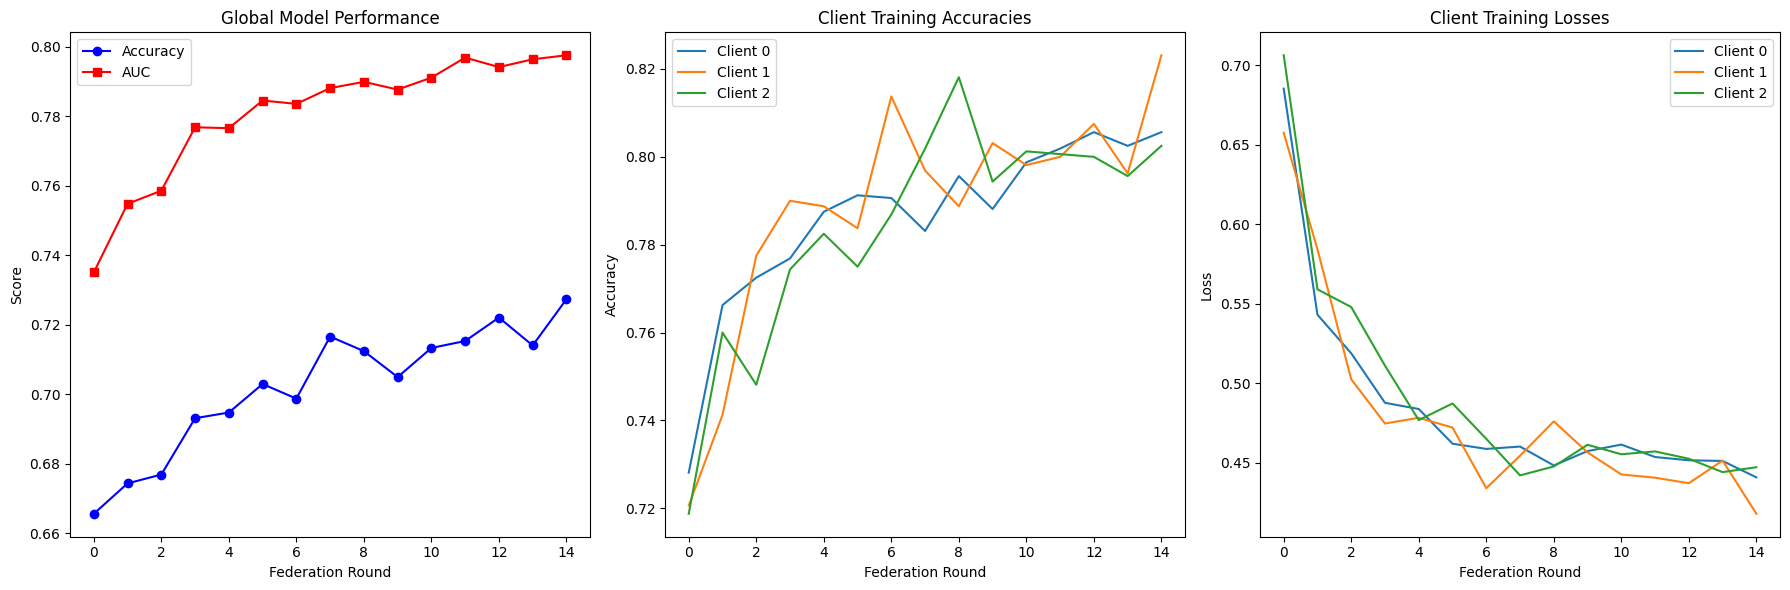


=== Final Model Evaluation ===
Model ready for deployment with:
- 15 federation rounds
- 5 epochs per client
- 3 participating clients


In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

# Enhanced Configuration
DATA_PATH = "C:/Users/musab/PycharmProjects/DataScienceGame/LOHITH_NEW/archive/Data"
CENTRAL_MODEL_PATH = "central_alzheimer_model(new).keras"
NUM_CLIENTS = 3
ROUNDS = 15  # Increased from 5 to 20
CLIENT_EPOCHS = 5  # Increased from 1 to 10
BATCH_SIZE = 32
TARGET_SIZE = (128, 128)
LEARNING_RATE = 0.0001
STEPS_PER_EPOCH = 50  # Reduced steps to accommodate more epochs

def create_client_datasets():
    """Create client datasets with enhanced augmentation"""
    clients = []
    for client_id in range(NUM_CLIENTS):
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            validation_split=0.2
        )
        
        train_gen = train_datagen.flow_from_directory(
            DATA_PATH,
            target_size=TARGET_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            subset='training',
            shuffle=True,
            seed=42 + client_id
        )
        
        val_gen = train_datagen.flow_from_directory(
            DATA_PATH,
            target_size=TARGET_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            subset='validation',
            shuffle=False,
            seed=42
        )
        
        print(f"\nClient {client_id} Data:")
        print(f"Training samples: {train_gen.samples}")
        print(f"Validation samples: {val_gen.samples}")
        print(f"Class distribution: {train_gen.class_indices}")
        
        clients.append({
            'train': train_gen,
            'val': val_gen,
            'train_steps': len(train_gen),
            'val_steps': len(val_gen)
        })
    return clients

def prepare_global_model():
    """Load and enhance existing central model"""
    global_model = load_model(CENTRAL_MODEL_PATH)
    
    # Architecture adaptation with enhanced layer
    if not any(isinstance(layer, GlobalAveragePooling2D) for layer in global_model.layers):
        print("Enhancing model architecture...")
        base_model = Model(inputs=global_model.inputs, 
                         outputs=global_model.layers[-2].output)
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(128, activation='relu')(x)  # Added dense layer
        predictions = Dense(1, activation='sigmoid')(x)
        global_model = Model(inputs=base_model.input, outputs=predictions)
    
    global_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return global_model

def federated_training():
    print("\n=== Enhanced Federated Learning ===")
    print(f"Running {ROUNDS} rounds with {CLIENT_EPOCHS} epochs per client")
    
    clients = create_client_datasets()
    global_model = prepare_global_model()
    
    # Enhanced tracking
    history = {
        'round': [],
        'val_accuracy': [],
        'val_auc': [],
        'client_losses': [[] for _ in range(NUM_CLIENTS)],
        'client_accuracies': [[] for _ in range(NUM_CLIENTS)]
    }
    
    # Baseline evaluation
    baseline_val = global_model.evaluate(clients[0]['val'], verbose=0)
    print(f"\nBaseline - Accuracy: {baseline_val[1]:.4f}, AUC: {baseline_val[2]:.4f}")
    
    for round in range(ROUNDS):
        print(f"\n=== Round {round+1}/{ROUNDS} ===")
        client_weights = []
        client_samples = []
        
        # Client training with progress bar
        for client_id in range(NUM_CLIENTS):
            print(f"\nClient {client_id} Training (Epochs: {CLIENT_EPOCHS})...")
            local_model = tf.keras.models.clone_model(global_model)
            local_model.set_weights(global_model.get_weights())
            local_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            history_local = local_model.fit(
                clients[client_id]['train'],
                steps_per_epoch=min(STEPS_PER_EPOCH, clients[client_id]['train_steps']),
                epochs=CLIENT_EPOCHS,
                verbose=1,
                validation_data=clients[client_id]['val'],
                validation_steps=min(20, clients[client_id]['val_steps'])
            )
            
            client_weights.append(local_model.get_weights())
            client_samples.append(clients[client_id]['train'].samples)
            history['client_losses'][client_id].append(history_local.history['loss'][-1])
            history['client_accuracies'][client_id].append(history_local.history['accuracy'][-1])
            
            del local_model
            gc.collect()
        
        # Enhanced weighted averaging
        avg_weights = [
            np.average(
                [weights[i] for weights in client_weights],
                axis=0,
                weights=client_samples
            )
            for i in range(len(client_weights[0]))
        ]
        global_model.set_weights(avg_weights)
        
        # Comprehensive evaluation
        val_results = global_model.evaluate(clients[0]['val'], verbose=0)
        history['round'].append(round)
        history['val_accuracy'].append(val_results[1])
        history['val_auc'].append(val_results[2])
        
        print(f"\nRound {round+1} Results:")
        print(f"Validation Accuracy: {val_results[1]:.4f}")
        print(f"Validation AUC: {val_results[2]:.4f}")
        
        # Periodic full evaluation
        if (round+1) % 5 == 0:  # Every 5 rounds
            val_gen = clients[0]['val']
            val_gen.reset()
            y_pred = (global_model.predict(val_gen, verbose=0) > 0.5).astype(int)
            print("\nDetailed Classification Report:")
            print(classification_report(val_gen.labels, y_pred, 
                                      target_names=val_gen.class_indices.keys()))
    
    # Save final model in modern format
    global_model.save('enhanced_alzheimer_model(FedAvg).keras')
    print("\nSaved enhanced model as 'enhanced_alzheimer_model.keras'")
    
    # Enhanced visualization
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['round'], history['val_accuracy'], 'b-o', label='Accuracy')
    plt.plot(history['round'], history['val_auc'], 'r-s', label='AUC')
    plt.title('Global Model Performance')
    plt.xlabel('Federation Round')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    for client_id in range(NUM_CLIENTS):
        plt.plot(history['round'], history['client_accuracies'][client_id], 
                label=f'Client {client_id}')
    plt.title('Client Training Accuracies')
    plt.xlabel('Federation Round')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    for client_id in range(NUM_CLIENTS):
        plt.plot(history['round'], history['client_losses'][client_id],
                label=f'Client {client_id}')
    plt.title('Client Training Losses')
    plt.xlabel('Federation Round')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('enhanced_training_progress.png', dpi=300)
    plt.show()
    
    return global_model

if __name__ == "__main__":
    # Run enhanced federated training
    final_model = federated_training()
    
    # Final comprehensive evaluation
    print("\n=== Final Model Evaluation ===")
    print("Model ready for deployment with:")
    print(f"- {ROUNDS} federation rounds")
    print(f"- {CLIENT_EPOCHS} epochs per client")
    print(f"- {NUM_CLIENTS} participating clients")

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# Load your dataset (modify paths as needed)
val_dir = "C:/Users/musab/PycharmProjects/DataScienceGame/LOHITH_NEW/archive/Data"
img_size = (224, 224)  # Adjust based on your model's input shape
batch_size = 32

val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
)

# Preprocess (normalize pixel values)
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

val_data = val_data.map(preprocess)

# Load models
centralized_model = load_model("central_alzheimer_model(new).keras")  # Replace with your .h5 path
federated_model = load_model("enhanced_alzheimer_model(FedAvg).keras")  # From federated training

# Evaluate both models
def evaluate_model(model, data):
    y_true = []
    y_pred = []
    y_probs = []

    for images, labels in data:
        y_true.extend(labels.numpy())
        probs = model.predict(images, verbose=0)
        y_probs.extend(probs.squeeze())
        y_pred.extend(np.argmax(probs, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Binary AUC (assuming binary classification)
    if len(np.unique(y_true)) == 2:
        auc = roc_auc_score(y_true, y_probs)
    else:
        auc = roc_auc_score(y_true, y_probs, multi_class='ovr')

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "auc": auc,
        "precision": precision_score(y_true, y_pred, average='macro'),
        "recall": recall_score(y_true, y_pred, average='macro'),
        "f1": f1_score(y_true, y_pred, average='macro'),
        "classification_report": classification_report(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred),
    }
    return metrics

# Run evaluations
central_metrics = evaluate_model(centralized_model, val_data)
federated_metrics = evaluate_model(federated_model, val_data)

# Print comparison
print("\n=== Centralized Model Metrics ===")
print(f"Accuracy: {central_metrics['accuracy']:.4f}")
print(f"AUC: {central_metrics['auc']:.4f}")
print(f"Precision: {central_metrics['precision']:.4f}")
print(f"Recall: {central_metrics['recall']:.4f}")
print(f"F1-Score: {central_metrics['f1']:.4f}")
print("\nClassification Report:")
print(central_metrics['classification_report'])

print("\n=== Federated Model Metrics ===")
print(f"Accuracy: {federated_metrics['accuracy']:.4f}")
print(f"AUC: {federated_metrics['auc']:.4f}")
print(f"Precision: {federated_metrics['precision']:.4f}")
print(f"Recall: {federated_metrics['recall']:.4f}")
print(f"F1-Score: {federated_metrics['f1']:.4f}")
print("\nClassification Report:")
print(federated_metrics['classification_report'])

# Confusion matrices (optional)
print("\nCentralized Model Confusion Matrix:")
print(central_metrics['confusion_matrix'])

print("\nFederated Model Confusion Matrix:")
print(federated_metrics['confusion_matrix'])

Found 27450 files belonging to 2 classes.


c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c


=== Centralized Model Metrics ===
Accuracy: 0.5000
AUC: 0.9215
Precision: 0.2500
Recall: 0.5000
F1-Score: 0.3333

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     13725
           1       0.00      0.00      0.00     13725

    accuracy                           0.50     27450
   macro avg       0.25      0.50      0.33     27450
weighted avg       0.25      0.50      0.33     27450


=== Federated Model Metrics ===
Accuracy: 0.5000
AUC: 0.8771
Precision: 0.2500
Recall: 0.5000
F1-Score: 0.3333

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     13725
           1       0.00      0.00      0.00     13725

    accuracy                           0.50     27450
   macro avg       0.25      0.50      0.33     27450
weighted avg       0.25      0.50      0.33     27450


Centralized Model Confusion Matrix:
[[13725     0]
 [13725     0]]

Fed

c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\musab\PycharmProjects\DataScienceGame\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier